<h1>Federated Learning of a Mixture of Global and Local models</h1>
<h3>Based on the <a href = "https://arxiv.org/pdf/2002.05516.pdf"> paper</a> by Filip Hanzely and Peter Richtárik.</h3>

<h2> New formulation of Federated Leaning </h2>

The main task of Federated Learning is:
$$
\min_{x_1, x_2, ..., x_n \in \mathbb{R}^d} F(x) 
$$
$$
F(x) = f(x) + \lambda \psi (x) 
$$
$$
f(x) = \frac{1}{n} \sum_{i = 1}^n f_i(x_i) 
$$
$$
\psi(x) = \frac{1}{2n} \sum_{i = 1}^n ||x_i - \overline{x}||^2
$$

<h2> Application in machine learning </h2>

Federated learning is a type of distributed learning. Let us add some certainity about its application.
In this notebook we will try to obtain the best weights for the logistic regression model, therefore we need to reformulate the task.
We have several devices and some dataset, we are trying to train model on.

* $\psi (w) = \frac{1}{2n} \sum_{i = 1}^{n} ||w_i - \overline{w}||^2$
This is a penalizer for difference between models. $\lambda
$ parameter regulates how it is important for device not to violate from the average model.
If $\lambda = 0$, $\lambda \psi(w)$ does not affect goal function $F(w)$, therefore we will have $n$ different models independently trained on different data. 
If $\lambda \rightarrow  \infty$,  $\psi(w)$ is infinitely important, therefore, if $\psi(w) \neq 0$, nothing else matters, and we will have $n$ identical models.

* $ f_i(w_i)$ is a loss function obtains from device weights and device data. In this notebook we will use Binary Cross Entropy for the Logistic Regression.
$f_i(w_i) = \frac{1}{s} \sum_{x_{i, j} \in S_i} BCE(w_i^T x_{i, j}, y_{i, j})$

Therefore, the whole task can be reformulated:

$$
    \min_{w_1, w_2, ..., w_n \in \mathbb{R}^d} \frac{1}{n} \sum_{i = 1}^{n}[\frac{1}{s} \sum_{x_{i, j} \in S_i} BCE(w_i^T x_{i, j}, y_{i, j})] + \frac{\lambda}{2n} \sum_{i = 1}^{n} ||w_i - \overline{w}||^2
$$
where:
* $n$ is a number of devices
* $d$ is a number of parameters equal to dimension of weight vector
* $w_i \in \mathbb{R}^{d}$ vector of weights stored on device $i$
* $S_i$ is a set of samples that belong to device $i$
* $x_{i, j} \in \mathbb{R}^d$ is a $j$-th sample on the device $i$
* $y_{i, j} \in \{0, 1\}$ is a $j$-th label on the device $i$ 
* $\overline{w}$ is a mean value of weights vector over all $n$ devices. 
* $BCE(y, \hat{y}) = -\frac{1}{k} \sum_{i = 1}^{k} (y_i \log(\hat{y}_i) + (1 - y_i) \cdot \log (1 - \hat{y}_i))$ if $y, \hat{y} \in \mathbb{R}^k$

<h1> Experiments </h1>

In this notebook we will use <a href="https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms"> "mushrooms" dataset </a> and <a href="https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/duke.bz2"> "a8a" dataset </a>.

We will examine two algorithms that were provided in the original paper: L2GD and L2SGD+

List of experiments:

* Influence of different $\lambda$ and $p$ parameters on the results of learning. (was in the original paper, page 24)
* Influence of the heterogeneity of data on the results of learning. (own experiment)

In [5]:
import random
import torch

from torch import Tensor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tqdm
from matplotlib import pyplot as plt
from LogisticRegression import LogisticRegression, L2GDNode, History, Division, L2SGD_plus_Node
from sklearn.datasets import load_svmlight_file

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(f'cuda:{torch.cuda.current_device()}') if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)
torch.set_grad_enabled(True)


<h3>Data Preprocessing</h3>

Reading the mushrooms and duke datasets, converting them to Tensors

In [3]:
df = pd.read_csv("mushrooms.csv")
df = pd.get_dummies(df, drop_first=True).astype(float)
y = df.class_p
X = df.drop('class_p', axis=1)
X.insert(0, "bias", np.ones(X.shape[0]))
X_train_m, X_test_m, y_train_m, y_test_m = (
    Tensor(i.to_numpy()).to(device) for i in train_test_split(X, y, test_size=0.33, random_state=239)
)
y_train_m = y_train_m.reshape(-1, 1)
y_test_m = y_test_m.reshape((-1, 1))
data = load_svmlight_file("a8a.txt")
X, y_raw = data[0].toarray(), data[1]
y = (y_raw + 1) // 2
X_train_d, X_test_d, y_train_d, y_test_d = (torch.nan_to_num(Tensor(i).to(device), nan=0.0) for i in train_test_split(X, y, test_size=0.2, random_state=42))
y_train_d = y_train_d.reshape((-1, 1))
y_test_d = y_test_d.reshape((-1, 1))

<h3> L2GD </h3>

Here is the pseudocode of the L2GD algorithm 
<a href="https://ibb.co/MNdqcnx"><img src="https://i.ibb.co/KynC26p/l2dg.jpg" alt="l2dg" border="0"></a>


In [5]:
def L2GD(nodes: list[L2GDNode], alpha: float, probability: float, lam: float, iterations, X_test, y_test) -> History:
    nodesAmount = len(nodes)
    average_model_history = History()
    coeff = alpha * lam / nodesAmount / probability
    assert 0 <= probability <= 1 and 0 <= coeff <= 1
    
    for k in tqdm.tqdm(range(iterations)):
        if not random.random() < probability or k == 0:
            for node in nodes:
                loss = node.model.forward_pass()
                loss.backward()
                with torch.no_grad():
                    node.model.weight += -1 * alpha / nodesAmount / (1 - probability) * node.model.weight.grad
                node.model.weight.grad.zero_()
                node.history.loss_history.append(loss.item())
        else:
            with torch.no_grad():
                average = sum(node.model.weight for node in nodes) / nodesAmount
                for node in nodes:
                    delta = ((1 - coeff) * node.model.weight + coeff * average) - node.model.weight
                    node.model.weight += delta
                    node.model.weight.grad.zero_()

        # MID EVALUATION
        with torch.no_grad():
            for node in nodes:
                node.history.accuracy_history.append(node.get_accuracy(X_test, y_test))
                node.history.local_accuracy_history.append(node.get_accuracy())
            av_model = LogisticRegression(X_test, y_test)
            av_model.weight += sum(node.model.weight for node in nodes) / nodesAmount
            y_pred = av_model.predict(X_test)
            average_model_accuracy_score = accuracy_score(y_pred.to("cpu"), y_test.to("cpu"))
            average_model_history.accuracy_history.append(average_model_accuracy_score)
    return average_model_history

<h3>Experiment 1. Influence of value of $\lambda$ on speed and accuracy of learning in L2GD</h3>

During this experiment we will randomly distribute data between several nodes. Then we will run the L2GD algorithm with different value of lambda to compare the speed and results of learning on both datasets.

This is the code for experiment with mushrooms:

In [15]:
K_HAT = 1000
PROBABILITY = 0.1

N_M = 12
ALPHA_M = 0.1
LAMBDA_M_VARIANTS = np.linspace(0, 5, 6)
nodes_l2gd_ex1_m = []
av_history_l2gd_ex1_m = []
amount_m = [random.randint(1, X_train_m.size()[0]) for i in range(N_M)]
percentage_m = [random.random() for i in range(N_M)]
for i in range(len(LAMBDA_M_VARIANTS)):
    # print(f'Training with LAMBDA = {LAMBDA_M_VARIANTS[i]}')
    nodes = [L2GDNode.createFromDivision(X_train_m, y_train_m, Division(amount_m[i], percentage_m[i])) for i in range(N_M)]
    av_history_m = L2GD(nodes, ALPHA_M, PROBABILITY, LAMBDA_M_VARIANTS[i], K_HAT, X_test_m, y_test_m)
    nodes_l2gd_ex1_m.append(nodes)
    av_history_l2gd_ex1_m.append(av_history_m)

100%|██████████| 1000/1000 [00:31<00:00, 31.66it/s]


In [16]:
N_D = 12
ALPHA_D = 0.1
LAMBDA_D_VARIANTS = np.linspace(0, 5, 6)
nodes_l2gd_ex1_d = []
av_history_l2gd_ex1_d = []
amount_d = [random.randint(1, X_train_d.size()[0]) for i in range(N_D)]
percentage_d = [random.random() for i in range(N_D)]
for i in range(len(LAMBDA_D_VARIANTS)):
    # print(f'Training with LAMBDA = {LAMBDA_D_VARIANTS[i]}')
    nodes = [L2GDNode.createFromDivision(X_train_d, y_train_d, Division(amount_d[i], percentage_d[i])) for i in range(N_D)]
    av_history_d = L2GD(nodes, ALPHA_D, PROBABILITY, LAMBDA_D_VARIANTS[i], K_HAT, X_test_d, y_test_d)
    nodes_l2gd_ex1_d.append(nodes)
    av_history_l2gd_ex1_d.append(av_history_d)

100%|██████████| 1000/1000 [00:39<00:00, 25.53it/s]


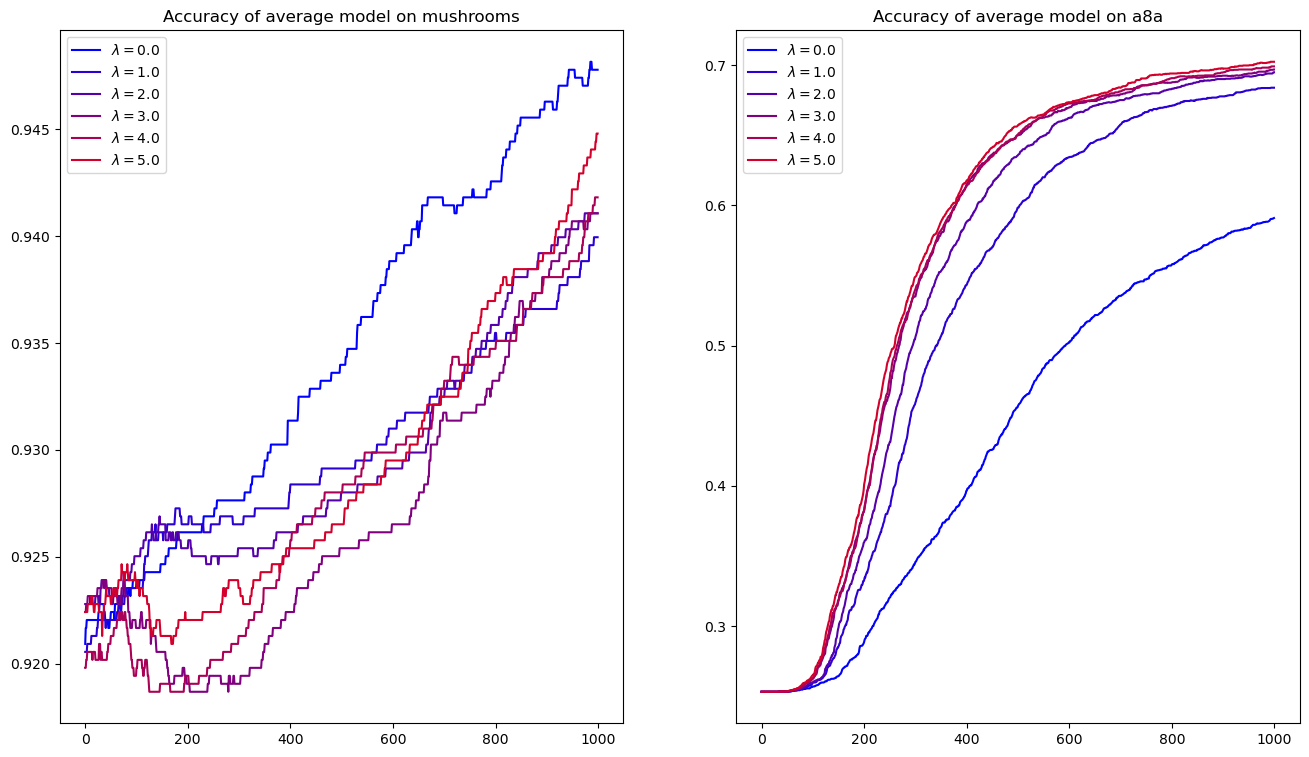

In [19]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(len(LAMBDA_M_VARIANTS)):
    av_history_m = av_history_l2gd_ex1_m[i]
    axs[0].plot(
        av_history_m.accuracy_history, 
        color = (1 / len(LAMBDA_M_VARIANTS) * i,0,  1 - 1 / len(LAMBDA_M_VARIANTS) * i), 
        label = f"$\lambda = {LAMBDA_M_VARIANTS[i]}$"
    )
    axs[0].set_title("Accuracy of average model on mushrooms")
    axs[0].legend()
for i in range(len(LAMBDA_D_VARIANTS)):
    av_history_d = av_history_l2gd_ex1_d[i]
    axs[1].plot(
        av_history_d.accuracy_history,
        color = (1 / len(LAMBDA_D_VARIANTS) * i,0,  1 - 1 / len(LAMBDA_D_VARIANTS) * i),
        label = f"$\lambda = {LAMBDA_D_VARIANTS[i]}$"
    )
    axs[1].set_title("Accuracy of average model on a8a")
    axs[1].legend()

__Conclusion__: There is no strict dependency between $\lambda$ and accuracy of average model. Highly likely this metrics does depend on the dataset.

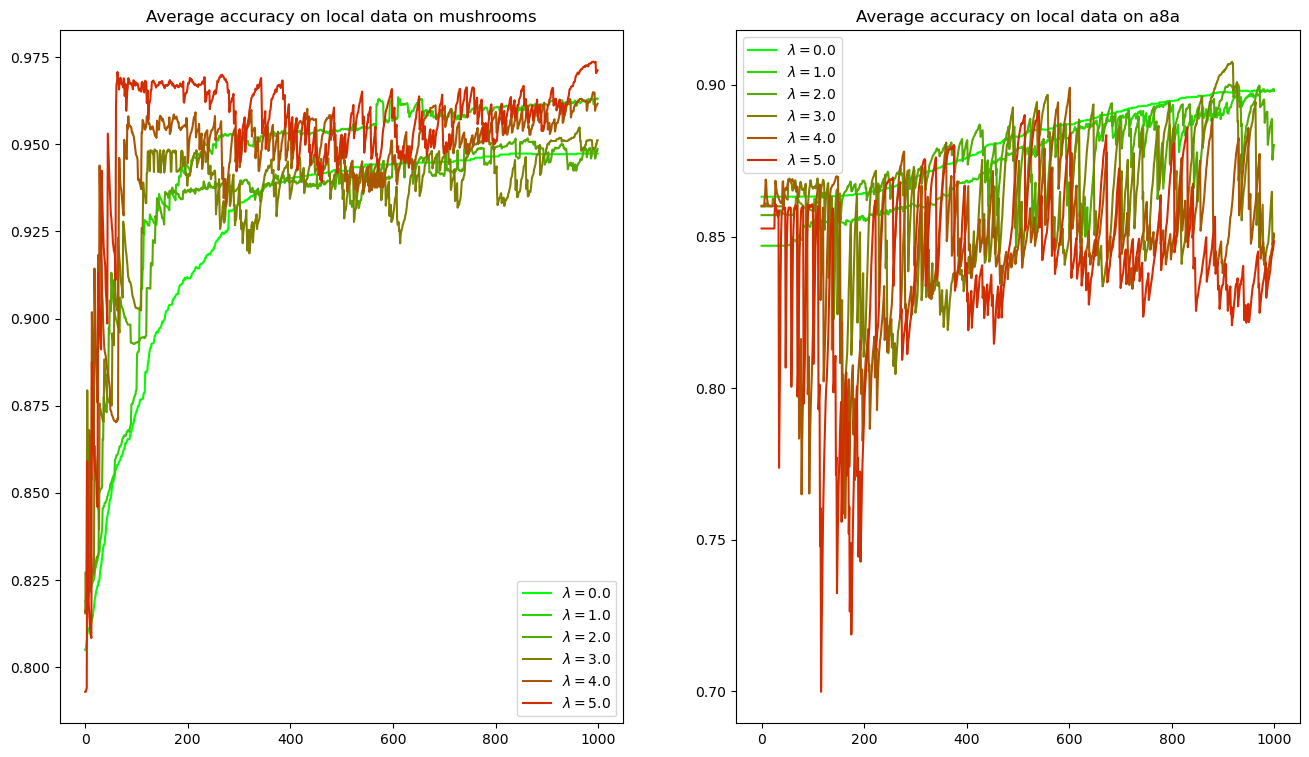

In [22]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(len(LAMBDA_M_VARIANTS)):
    nodes = nodes_l2gd_ex1_m[i]
    axs[0].plot(
        [
            sum([node.history.local_accuracy_history[i] for node in nodes]) / N_M
            for i in range(K_HAT)
        ],
        color = (1 / len(LAMBDA_M_VARIANTS) * i, 1 - 1 / len(LAMBDA_M_VARIANTS) * i, 0),
        label = f"$\lambda = {LAMBDA_M_VARIANTS[i]}$"
    )
    axs[0].set_title("Average accuracy on local data on mushrooms")
    axs[0].legend()
for i in range(len(LAMBDA_D_VARIANTS)):
    nodes = nodes_l2gd_ex1_d[i]
    axs[1].plot(
        [
            sum([node.history.local_accuracy_history[i] for node in nodes]) / N_D
            for i in range(K_HAT)
        ],
        color = (1 / len(LAMBDA_D_VARIANTS) * i, 1 - 1 / len(LAMBDA_D_VARIANTS) * i, 0),
        label = f"$\lambda = {LAMBDA_D_VARIANTS[i]}$"
    )
    axs[1].set_title("Average accuracy on local data on a8a")
    axs[1].legend()

__Conclusion__: High values of $\lambda$ can ruin the accuracy score on local data. Also, accuracy after aggregation step can not be predicted if value of loss function is not approaching 0.

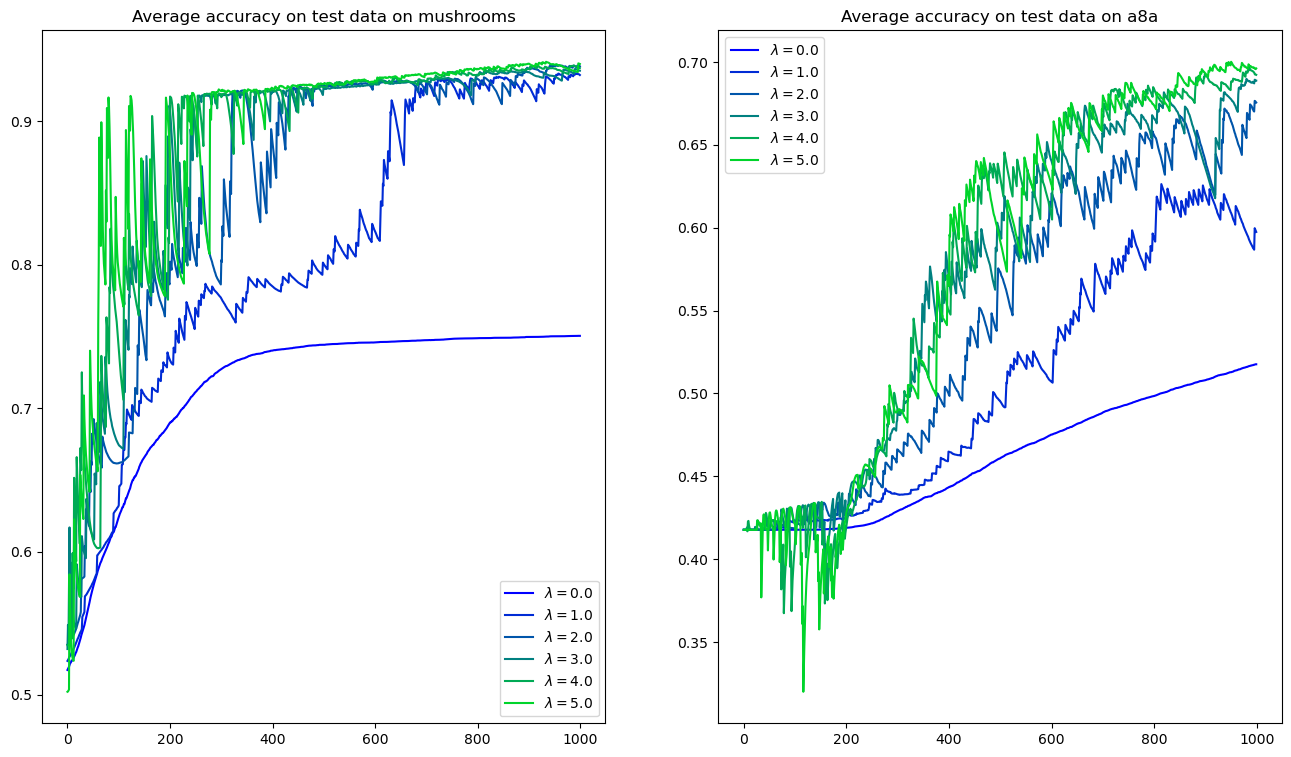

In [25]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(len(LAMBDA_M_VARIANTS)):
    nodes = nodes_l2gd_ex1_m[i]
    axs[0].plot(
        [
            sum([node.history.accuracy_history[i] for node in nodes]) / N_M
            for i in range(K_HAT)
        ],
        color = (0, 1 / len(LAMBDA_M_VARIANTS) * i, 1 - 1 / len(LAMBDA_M_VARIANTS) * i),
        label = f"$\lambda = {LAMBDA_M_VARIANTS[i]}$"
    )
    axs[0].set_title("Average accuracy on test data on mushrooms")
    axs[0].legend()
for i in range(len(LAMBDA_D_VARIANTS)):
    nodes = nodes_l2gd_ex1_d[i]
    axs[1].plot(
        [
            sum([node.history.accuracy_history[i] for node in nodes]) / N_D
            for i in range(K_HAT)
        ],
        color = (0, 1 / len(LAMBDA_D_VARIANTS) * i, 1 - 1 / len(LAMBDA_D_VARIANTS) * i),
        label = f"$\lambda = {LAMBDA_D_VARIANTS[i]}$"
    )
    axs[1].set_title("Average accuracy on test data on a8a")
    axs[1].legend()

__Conclusion__: Higher values of $\lambda$ result in better performance of local model on unseen data.

<h3> Experiment 2. Influence of data Heterogenity on speed and accuracy of learning in L2GD</h3>

In this experiment we will set $\lambda_m = 1$ for mushrooms dataset and $\lambda_d = 2$ for a8a dataset.
To understand the essence let us introduce new variable $v_i \in [0; 1]$, that represents the ratio of "1" labels to all labels stored on device $i$. $V = \{v_i\}_{i = 1}^n$
We will consider the variance of V $\sigma^2_V$ as a measure of heterogeneity. Each node will have $\frac{1}{12}$ part of the dataset

In [49]:
N_M = 12
ALPHA_M = 0.1
LAMBDA_M = 1
nodes_l2gd_ex2_m = []
av_history_l2gd_ex2_m = []
TRIALS = 6

trial_probs = []
variances = []
for trial_index in range(TRIALS):
    probs = np.random.poisson(50 - trial_index * 50 / TRIALS + 1, N_M) / 100
    for i in range(len(probs)): probs[i] = 1 - probs[i] if i % 2 == 0 else probs[i]
    trial_probs.append(probs)
    variances.append(np.var(probs))

In [51]:

for run in range(TRIALS):
    nodes = [L2GDNode.createFromDivision(X_train_m, y_train_m, Division(X_train_m.size()[0]//12, trial_probs[run][i])) for i in range(N_M)]
    av_history_m = L2GD(nodes, ALPHA_M, PROBABILITY, LAMBDA_M, K_HAT, X_test_m, y_test_m)
    nodes_l2gd_ex2_m.append(nodes)
    av_history_l2gd_ex2_m.append(av_history_m)

100%|██████████| 1000/1000 [00:39<00:00, 25.40it/s]


In [52]:
N_D = 12
ALPHA_D = 0.1
LAMBDA_D = 2
nodes_l2gd_ex2_d = []
av_history_l2gd_ex2_d = []

for run in range(TRIALS):
    nodes = [L2GDNode.createFromDivision(X_train_d, y_train_d, Division(X_train_d.size()[0]//12, trial_probs[run][i])) for i in range(N_D)]
    av_history_d = L2GD(nodes, ALPHA_D, PROBABILITY, LAMBDA_D, K_HAT, X_test_d, y_test_d)
    nodes_l2gd_ex2_d.append(nodes)
    av_history_l2gd_ex2_d.append(av_history_d)

100%|██████████| 1000/1000 [00:44<00:00, 22.48it/s]


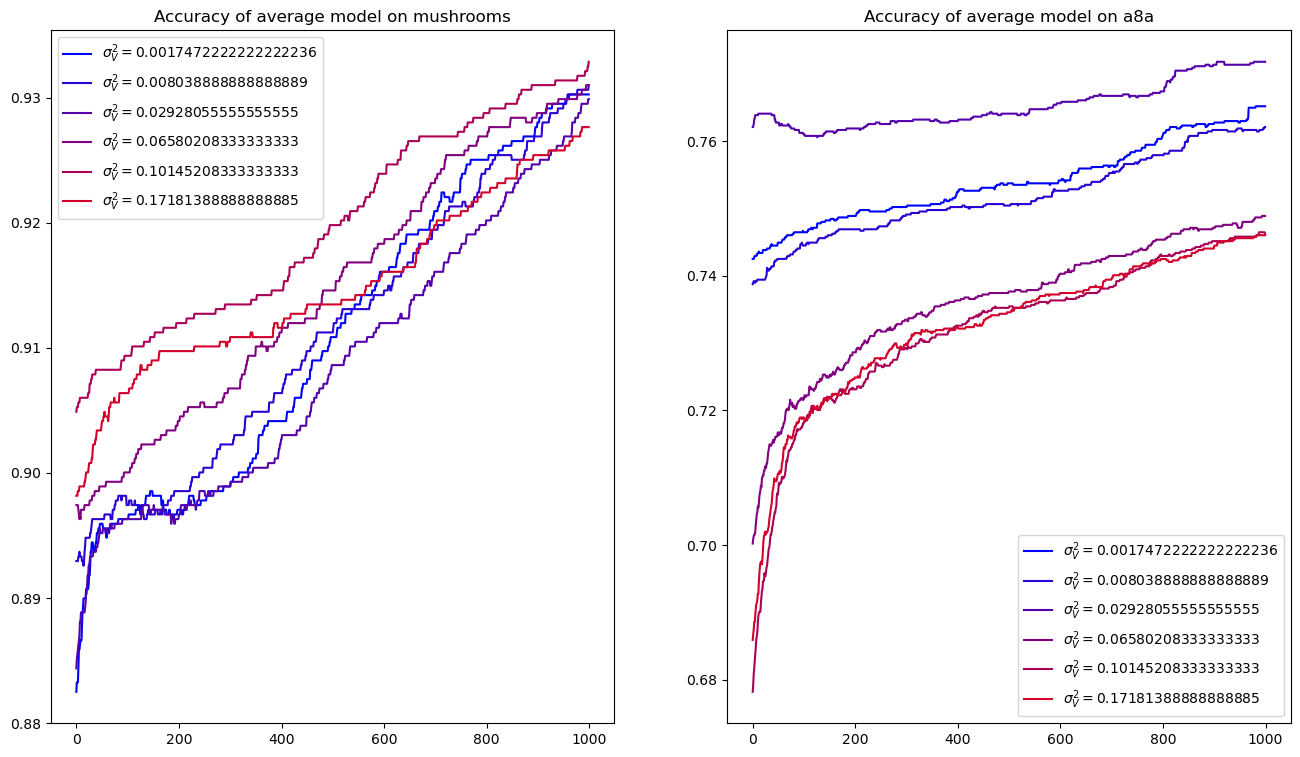

In [55]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(TRIALS):
    av_history_m = av_history_l2gd_ex2_m[i]
    axs[0].plot(
        av_history_m.accuracy_history,
        color = (1 / TRIALS * i,0,  1 - 1 / TRIALS * i),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[0].set_title("Accuracy of average model on mushrooms")
    axs[0].legend()
for i in range(TRIALS):
    av_history_d = av_history_l2gd_ex2_d[i]
    axs[1].plot(
        av_history_d.accuracy_history,
        color = (1 / TRIALS * i,0,  1 - 1 / TRIALS * i),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[1].set_title("Accuracy of average model on a8a")
    axs[1].legend()

__Conclusion__: There is no strict dependency between heterogeneity of data and performance of the average model. 

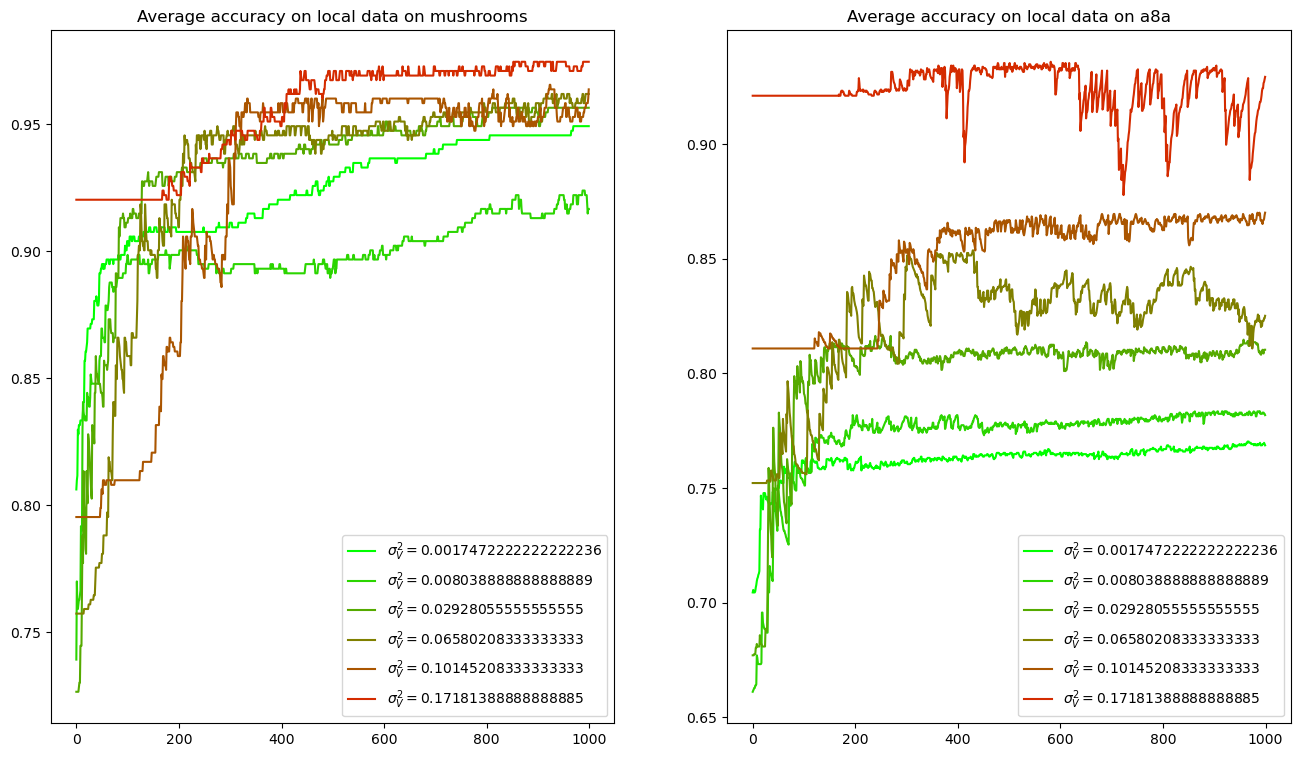

In [56]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(TRIALS):
    nodes = nodes_l2gd_ex2_m[i]
    axs[0].plot(
        [
            sum([node.history.local_accuracy_history[i] for node in nodes]) / N_M
            for i in range(K_HAT)
        ],
        color = (1 / TRIALS * i, 1 - 1 / TRIALS * i, 0),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[0].set_title("Average accuracy on local data on mushrooms")
    axs[0].legend()
for i in range(TRIALS):
    nodes = nodes_l2gd_ex2_d[i]
    axs[1].plot(
        [
            sum([node.history.local_accuracy_history[i] for node in nodes]) / N_D
            for i in range(K_HAT)
        ],
        color = (1 / TRIALS * i, 1 - 1 / TRIALS * i, 0),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[1].set_title("Average accuracy on local data on a8a")
    axs[1].legend()

__Conclusion__: Heterogeneity of data in the tasks of binary classification leads to higher accuracy. But in this experiment accuracy can not be considered as a fait metric cause datasets are unbalanced on each device.


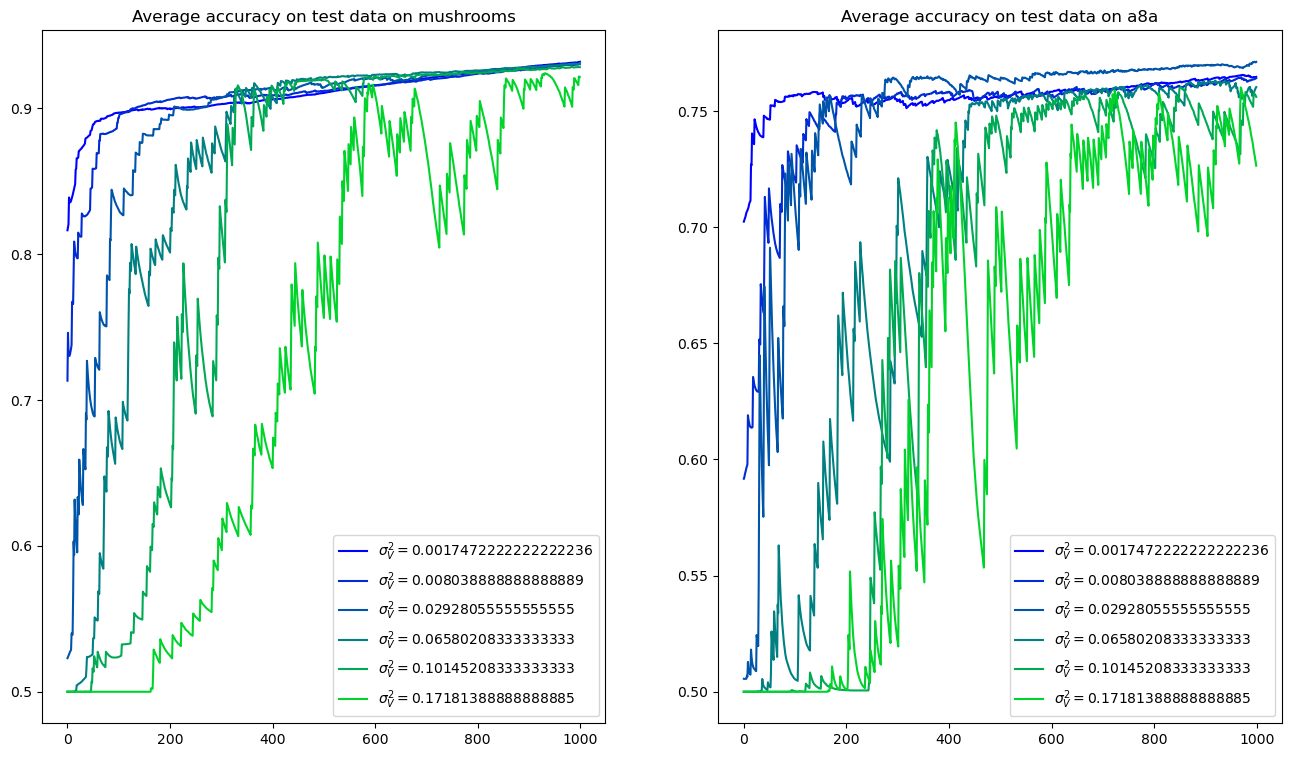

In [57]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(TRIALS):
    nodes = nodes_l2gd_ex2_m[i]
    axs[0].plot(
        [
            sum([node.history.accuracy_history[i] for node in nodes]) / N_M
            for i in range(K_HAT)
        ],
        color = (0, 1 / TRIALS * i, 1 - 1 / TRIALS * i),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[0].set_title("Average accuracy on test data on mushrooms")
    axs[0].legend()
for i in range(TRIALS):
    nodes = nodes_l2gd_ex2_d[i]
    axs[1].plot(
        [
            sum([node.history.accuracy_history[i] for node in nodes]) / N_D
            for i in range(K_HAT)
        ],
        color = (0, 1 / TRIALS * i, 1 - 1 / TRIALS * i),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[1].set_title("Average accuracy on test data on a8a")
    axs[1].legend()

__Conclusion__: Either with heterogeneous data on each device, total performance on unseen data is satisfactory because of aggregation.

__Total conclusion__:

Bigger values of $\lambda$ lead to better performance on device on unseen data but performance on local data is suffering. This conclusion is true even if data is very heterogeneous.

<h3> L2SGD+ </h3>
This is the federated learning method that has a lot of in common with SAGA.

<a href="https://ibb.co/qxvP8Bk"><img src="https://i.ibb.co/pnS9T2J/l2sdg.jpg" alt="l2sdg" border="0"></a>

In [15]:
def L2SGD_plus(nodes, learning_rate, probability, lam, iterations, m, X_test, y_test):
    average_model_history = History()
    nodesAmount = len(nodes)
    for k in tqdm.tqdm(range(iterations)):
        if random.random() > probability or k == 0:
        # if 1 > probability:
            for node in nodes:
                j = random.randint(0, m - 1)
                # And here the forward pass appears
                batch_X, batch_y = node.get_minibatch(j)
                loss = node.model.forward_pass(batch_X, batch_y)
                loss.backward()
                with torch.no_grad():
                    iteration_grad = node.model.weight.grad
                    # print(f"iteration grad for the node is {iteration_grad}")
                    update_difference = (iteration_grad - node.J[:, j]) / nodesAmount / (1 - probability)
                    averaging_trail = node.J @ (torch.ones(m).to(device)) / nodesAmount / m
                    federated_penalty = node.psi / nodesAmount
                    g = update_difference + averaging_trail + federated_penalty
                    # print(g.size())
                    node.model.weight -= learning_rate * g
                    node.J[:, j] = iteration_grad                   
                node.model.weight.grad.zero_()
        else:
            average_weight = sum([node.model.weight for node in nodes]) / nodesAmount
            for node in nodes:
                with torch.no_grad():
                    individuality_factor = lam / nodesAmount / probability * (node.model.weight - average_weight)
                    psi_trail = (probability * -1  - 1 ) / nodesAmount * node.psi
                    j_trail = 1 / nodesAmount / m * node.J @ torch.ones(m).to(device).T
                    g_i_k = individuality_factor - psi_trail + j_trail
                    # print(g_i_k.size())
                    node.model.weight -= learning_rate * g_i_k
                    node.psi = lam * (node.model.weight - average_weight)
                node.model.weight.grad.zero_()
        
        with torch.no_grad():
            av_model = LogisticRegression(X_test, y_test)
            av_model.weight += sum([node.model.weight for node in nodes])
            average_model_history.accuracy_history.append(
                accuracy_score(
                    av_model.predict(X_test).to("cpu"),
                    y_test.to("cpu")
                )
            )
            for node in nodes:
                node.history.accuracy_history.append(node.get_accuracy(X_test, y_test))
                node.history.local_accuracy_history.append(node.get_accuracy())
    return average_model_history

In [16]:
K_HAT = 1000
PROBABILITY = 0.1

M = 10
N_M = 12
ALPHA_M = 0.1
LAMBDA_M_VARIANTS = np.linspace(0, 5, 6)
nodes_l2sgdp_ex1_m = []
av_history_l2sgdp_ex1_m = []
amount_m = [random.randint(1, X_train_m.size()[0]) for i in range(N_M)]
percentage_m = [random.random() for i in range(N_M)]
for i in range(len(LAMBDA_M_VARIANTS)):
    # print(f'Training with LAMBDA = {LAMBDA_M_VARIANTS[i]}')
    nodes = [L2SGD_plus_Node.createFromDivision(X_train_m, y_train_m, M, Division(amount_m[i], percentage_m[i])) for i in range(N_M)]
    av_history_m = L2SGD_plus(nodes, ALPHA_M, PROBABILITY, LAMBDA_M_VARIANTS[i], K_HAT, M, X_test_m, y_test_m)
    nodes_l2sgdp_ex1_m.append(nodes)
    av_history_l2sgdp_ex1_m.append(av_history_m)

100%|██████████| 1000/1000 [00:40<00:00, 24.69it/s]


In [17]:
K_HAT = 1000
PROBABILITY = 0.1
M = 10

N_D = 12
ALPHA_D = 0.1
LAMBDA_D_VARIANTS = np.linspace(0, 5, 6)
nodes_l2sgdp_ex1_d = []
av_history_l2sgdp_ex1_d = []
amount_d = [random.randint(1, X_train_d.size()[0]) for i in range(N_D)]
percentage_d = [random.random() for i in range(N_D)]
for i in range(len(LAMBDA_D_VARIANTS)):
    # print(f'Training with LAMBDA = {LAMBDA_M_VARIANTS[i]}')
    nodes = [L2SGD_plus_Node.createFromDivision(X_train_d, y_train_d, M, Division(amount_d[i], percentage_d[i])) for i in range(N_D)]
    av_history_d = L2SGD_plus(nodes, ALPHA_D, PROBABILITY, LAMBDA_D_VARIANTS[i], K_HAT, M, X_test_d, y_test_d)
    nodes_l2sgdp_ex1_d.append(nodes)
    av_history_l2sgdp_ex1_d.append(av_history_d)

100%|██████████| 1000/1000 [00:48<00:00, 20.79it/s]


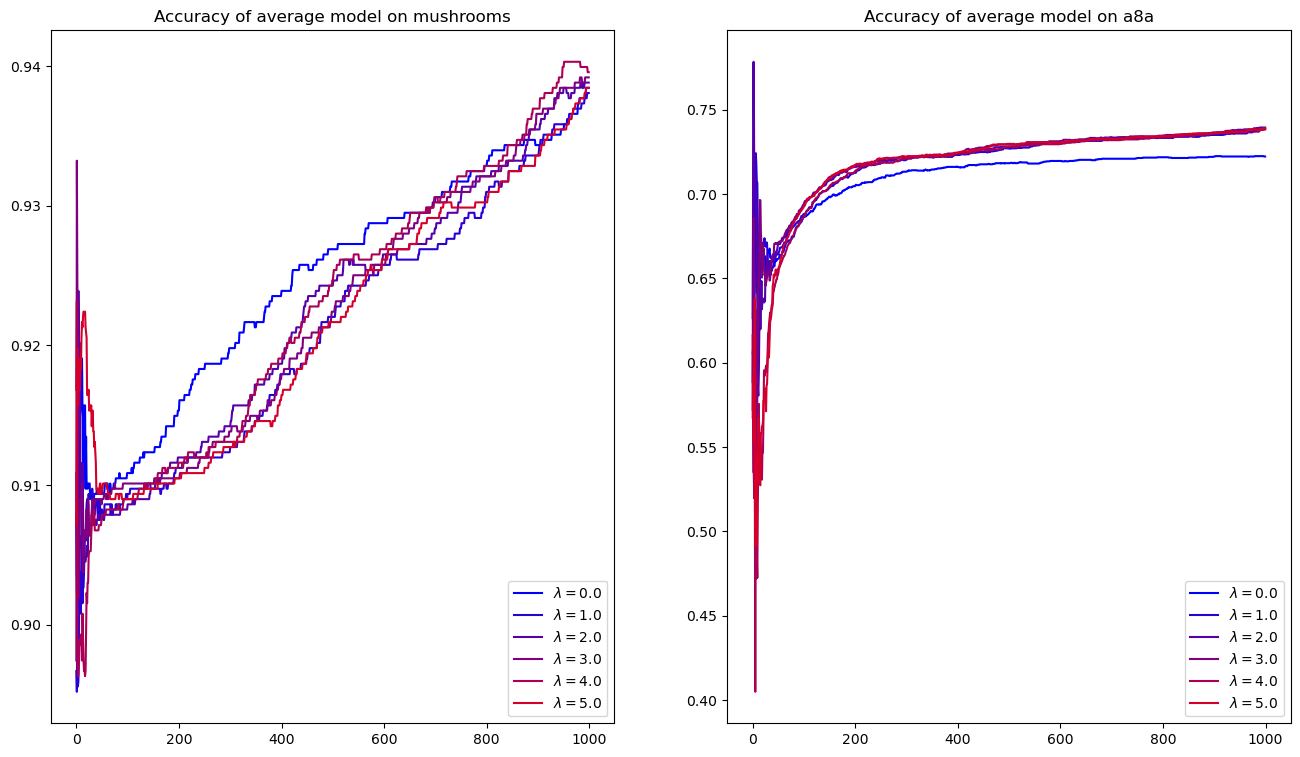

In [18]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(len(LAMBDA_M_VARIANTS)):
    av_history_m = av_history_l2sgdp_ex1_m[i]
    axs[0].plot(
        av_history_m.accuracy_history,
        color = (1 / len(LAMBDA_M_VARIANTS) * i,0,  1 - 1 / len(LAMBDA_M_VARIANTS) * i),
        label = f"$\lambda = {LAMBDA_M_VARIANTS[i]}$"
    )
    axs[0].set_title("Accuracy of average model on mushrooms")
    axs[0].legend()
for i in range(len(LAMBDA_D_VARIANTS)):
    av_history_d = av_history_l2sgdp_ex1_d[i]
    axs[1].plot(
        av_history_d.accuracy_history,
        color = (1 / len(LAMBDA_D_VARIANTS) * i,0,  1 - 1 / len(LAMBDA_D_VARIANTS) * i),
        label = f"$\lambda = {LAMBDA_D_VARIANTS[i]}$"
    )
    axs[1].set_title("Accuracy of average model on a8a")
    axs[1].legend()

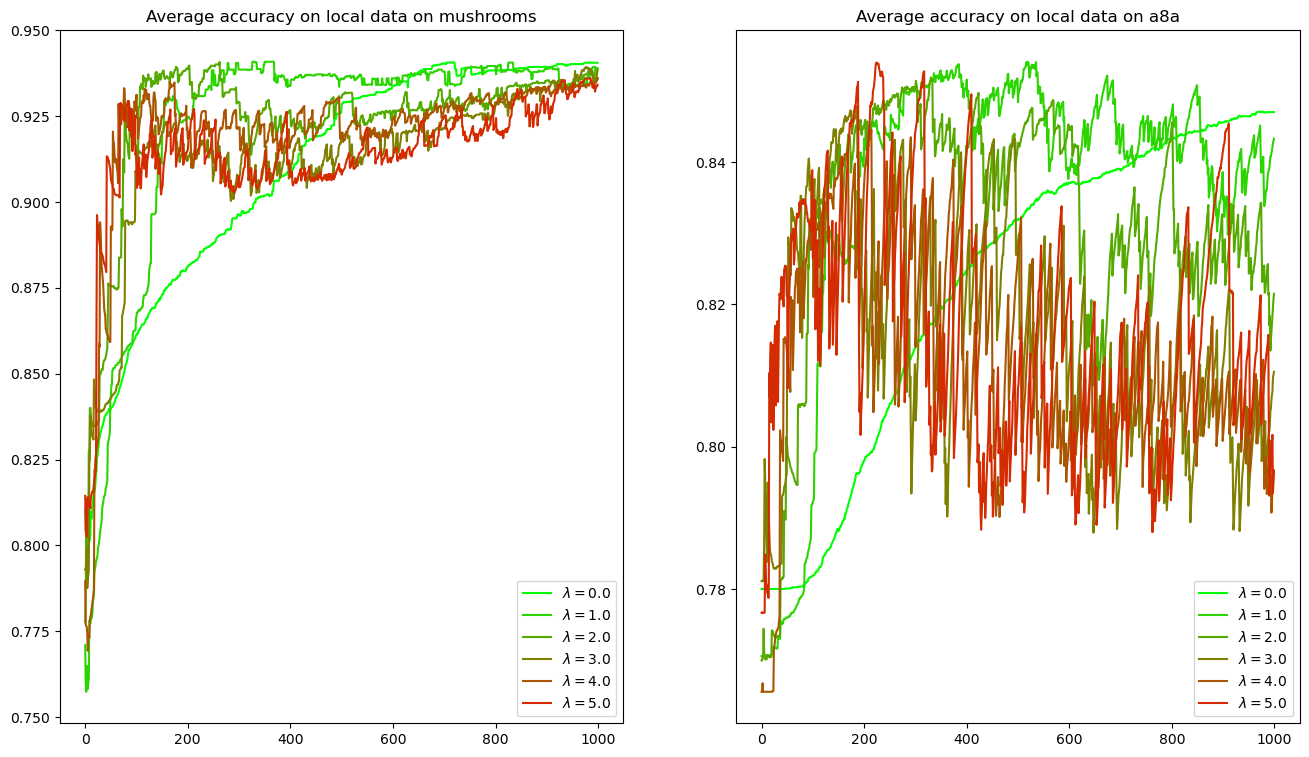

In [19]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(len(LAMBDA_M_VARIANTS)):
    nodes = nodes_l2sgdp_ex1_m[i]
    axs[0].plot(
        [
            sum([node.history.local_accuracy_history[i] for node in nodes]) / N_M
            for i in range(K_HAT)
        ],
        color = (1 / len(LAMBDA_M_VARIANTS) * i, 1 - 1 / len(LAMBDA_M_VARIANTS) * i, 0),
        label = f"$\lambda = {LAMBDA_M_VARIANTS[i]}$"
    )
    axs[0].set_title("Average accuracy on local data on mushrooms")
    axs[0].legend()
for i in range(len(LAMBDA_D_VARIANTS)):
    nodes = nodes_l2sgdp_ex1_d[i]
    axs[1].plot(
        [
            sum([node.history.local_accuracy_history[i] for node in nodes]) / N_D
            for i in range(K_HAT)
        ],
        color = (1 / len(LAMBDA_D_VARIANTS) * i, 1 - 1 / len(LAMBDA_D_VARIANTS) * i, 0),
        label = f"$\lambda = {LAMBDA_D_VARIANTS[i]}$"
    )
    axs[1].set_title("Average accuracy on local data on a8a")
    axs[1].legend()

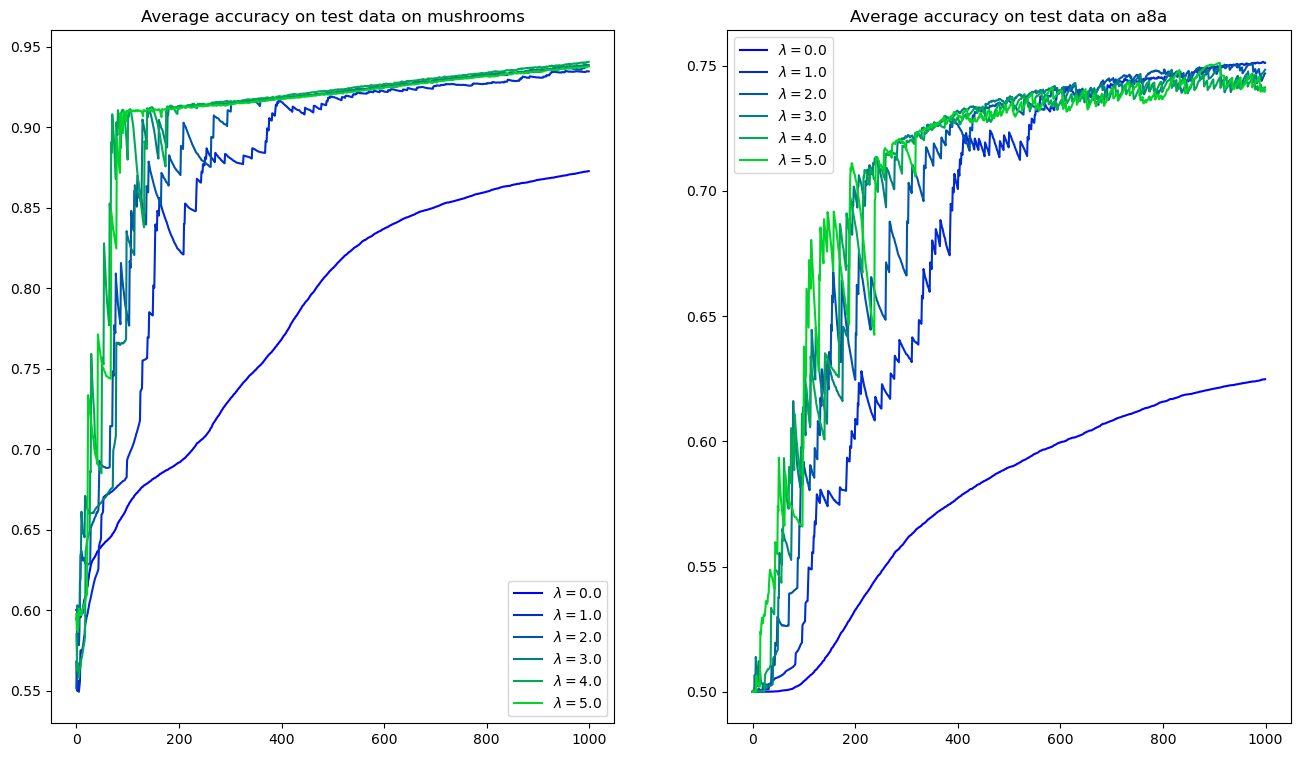

In [20]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(len(LAMBDA_M_VARIANTS)):
    nodes = nodes_l2sgdp_ex1_m[i]
    axs[0].plot(
        [
            sum([node.history.accuracy_history[i] for node in nodes]) / N_M
            for i in range(K_HAT)
        ],
        color = (0, 1 / len(LAMBDA_M_VARIANTS) * i, 1 - 1 / len(LAMBDA_M_VARIANTS) * i),
        label = f"$\lambda = {LAMBDA_M_VARIANTS[i]}$"
    )
    axs[0].set_title("Average accuracy on test data on mushrooms")
    axs[0].legend()
for i in range(len(LAMBDA_D_VARIANTS)):
    nodes = nodes_l2sgdp_ex1_d[i]
    axs[1].plot(
        [
            sum([node.history.accuracy_history[i] for node in nodes]) / N_D
            for i in range(K_HAT)
        ],
        color = (0, 1 / len(LAMBDA_D_VARIANTS) * i, 1 - 1 / len(LAMBDA_D_VARIANTS) * i),
        label = f"$\lambda = {LAMBDA_D_VARIANTS[i]}$"
    )
    axs[1].set_title("Average accuracy on test data on a8a")
    axs[1].legend()

In [21]:
N_M = 12
ALPHA_M = 0.1
LAMBDA_M = 1
nodes_l2sgdp_ex2_m = []
av_history_l2sgdp_ex2_m = []
TRIALS = 6

trial_probs = []
variances = []
for trial_index in range(TRIALS):
    probs = np.random.poisson(50 - trial_index * 50 / TRIALS + 1, N_M) / 100
    for i in range(len(probs)): probs[i] = 1 - probs[i] if i % 2 == 0 else probs[i]
    trial_probs.append(probs)
    variances.append(np.var(probs))

In [22]:
for run in range(TRIALS):
    nodes = [L2SGD_plus_Node.createFromDivision(X_train_m, y_train_m, M, Division(X_train_m.size()[0]//12, trial_probs[run][i])) for i in range(N_M)]
    av_history_m = L2SGD_plus(nodes, ALPHA_M, PROBABILITY, LAMBDA_M, K_HAT, M, X_test_m, y_test_m)
    nodes_l2sgdp_ex2_m.append(nodes)
    av_history_l2sgdp_ex2_m.append(av_history_m)

100%|██████████| 1000/1000 [00:35<00:00, 27.82it/s]


In [23]:
N_D = 12
ALPHA_D = 0.1
LAMBDA_D = 2
nodes_l2sgdp_ex2_d = []
av_history_l2sgdp_ex2_d = []

for run in range(TRIALS):
    nodes = [L2SGD_plus_Node.createFromDivision(X_train_d, y_train_d, M, Division(X_train_d.size()[0]//12, trial_probs[run][i])) for i in range(N_D)]
    av_history_d = L2SGD_plus(nodes, ALPHA_D, PROBABILITY, LAMBDA_D, K_HAT, M, X_test_d, y_test_d)
    nodes_l2sgdp_ex2_d.append(nodes)
    av_history_l2sgdp_ex2_d.append(av_history_d)

100%|██████████| 1000/1000 [00:41<00:00, 24.18it/s]


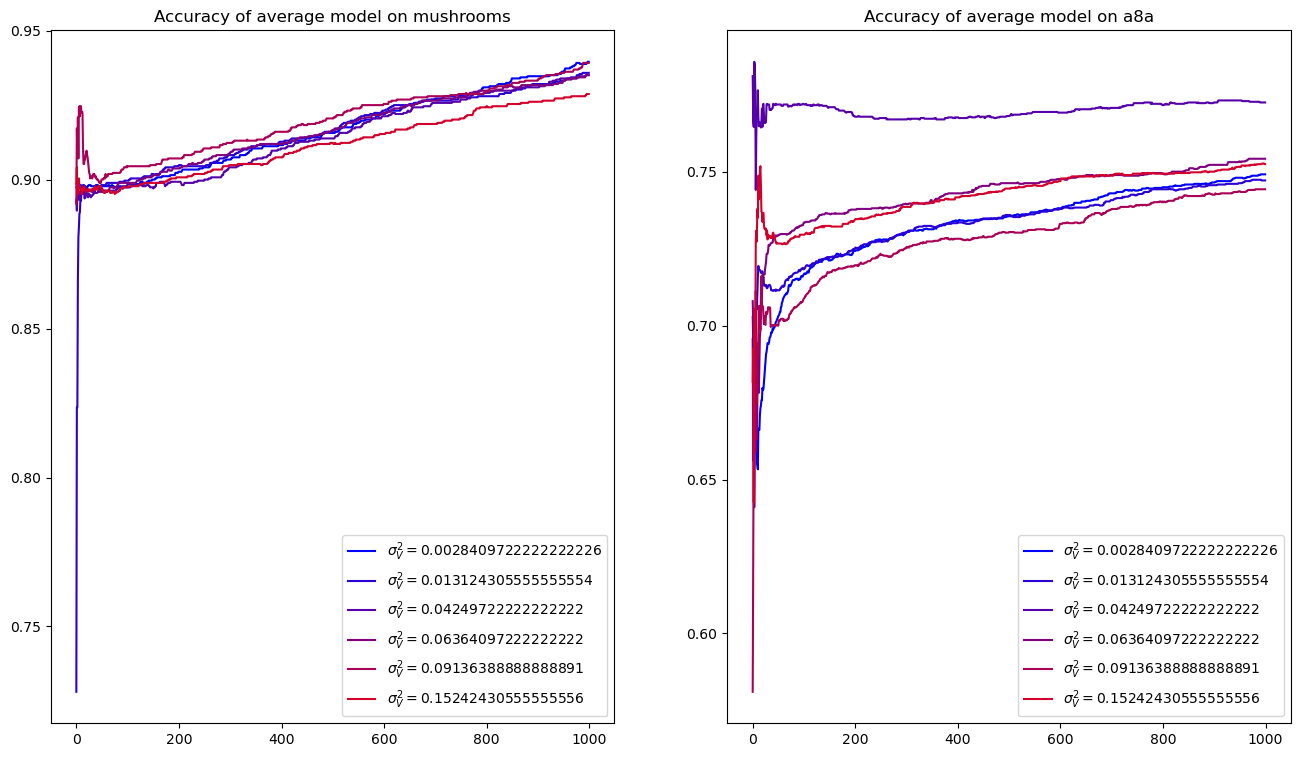

In [24]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(TRIALS):
    av_history_m = av_history_l2sgdp_ex2_m[i]
    axs[0].plot(
        av_history_m.accuracy_history,
        color = (1 / TRIALS * i,0,  1 - 1 / TRIALS * i),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[0].set_title("Accuracy of average model on mushrooms")
    axs[0].legend()
for i in range(TRIALS):
    av_history_d = av_history_l2sgdp_ex2_d[i]
    axs[1].plot(
        av_history_d.accuracy_history,
        color = (1 / TRIALS * i,0,  1 - 1 / TRIALS * i),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[1].set_title("Accuracy of average model on a8a")
    axs[1].legend()

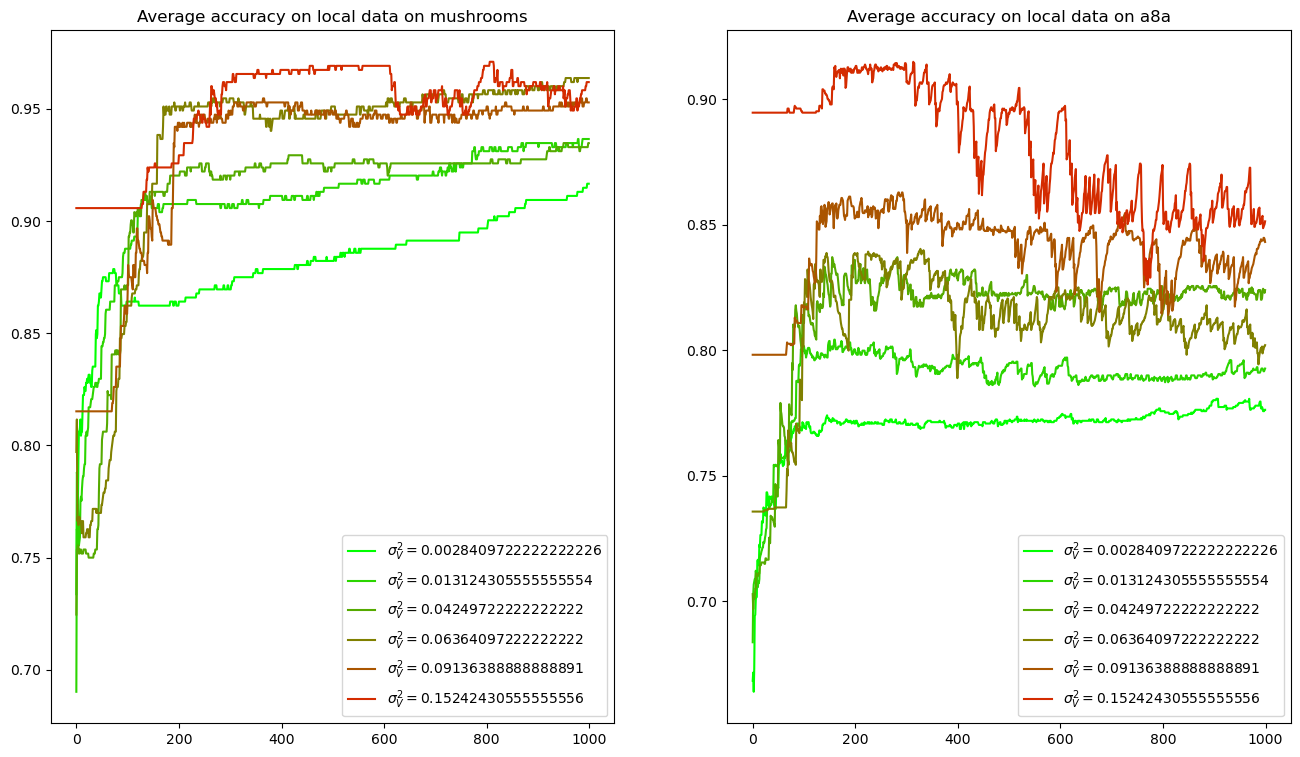

In [25]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(TRIALS):
    nodes = nodes_l2sgdp_ex2_m[i]
    axs[0].plot(
        [
            sum([node.history.local_accuracy_history[i] for node in nodes]) / N_M
            for i in range(K_HAT)
        ],
        color = (1 / TRIALS * i, 1 - 1 / TRIALS * i, 0),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[0].set_title("Average accuracy on local data on mushrooms")
    axs[0].legend()
for i in range(TRIALS):
    nodes = nodes_l2sgdp_ex2_d[i]
    axs[1].plot(
        [
            sum([node.history.local_accuracy_history[i] for node in nodes]) / N_D
            for i in range(K_HAT)
        ],
        color = (1 / TRIALS * i, 1 - 1 / TRIALS * i, 0),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[1].set_title("Average accuracy on local data on a8a")
    axs[1].legend()

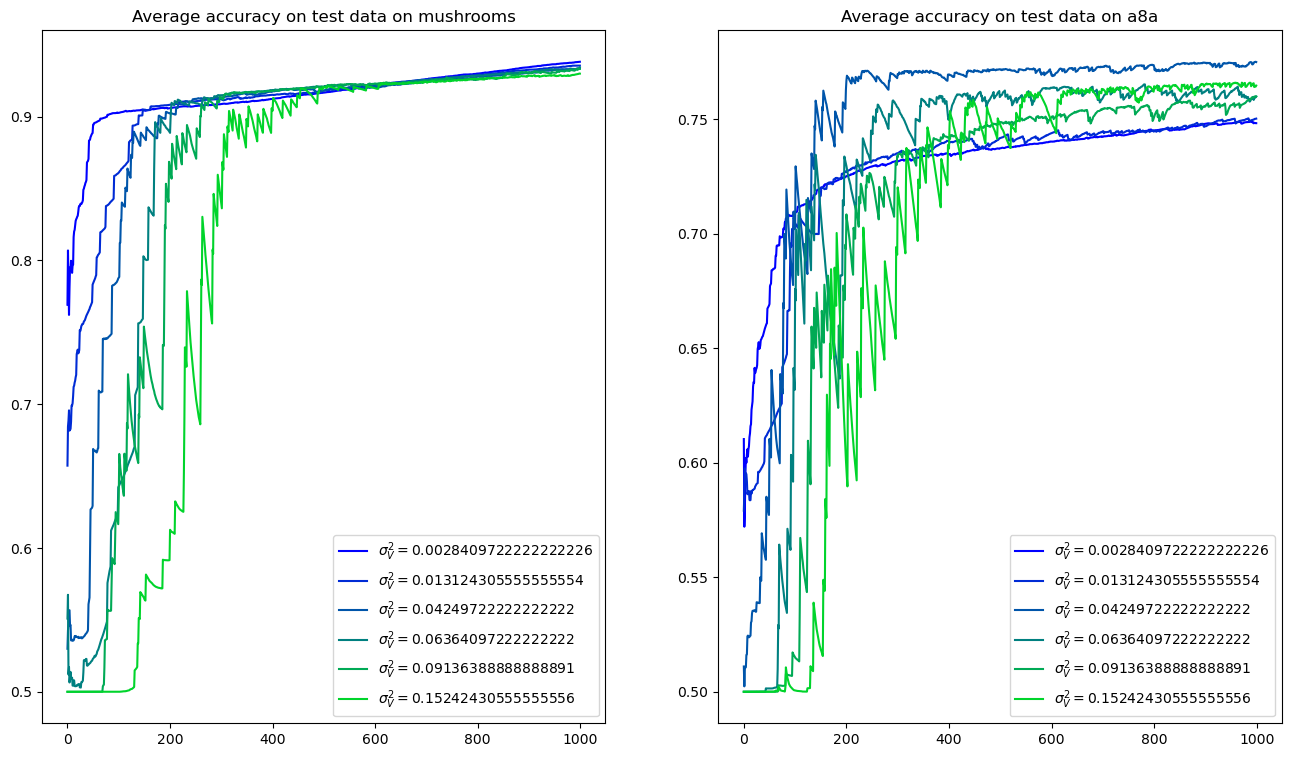

In [27]:
f, axs = plt.subplots(1, 2)
f.set_figheight(9)
f.set_figwidth(16)
for i in range(TRIALS):
    nodes = nodes_l2sgdp_ex2_m[i]
    axs[0].plot(
        [
            sum([node.history.accuracy_history[i] for node in nodes]) / N_M
            for i in range(K_HAT)
        ],
        color = (0, 1 / TRIALS * i, 1 - 1 / TRIALS * i),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[0].set_title("Average accuracy on test data on mushrooms")
    axs[0].legend()
for i in range(TRIALS):
    nodes = nodes_l2sgdp_ex2_d[i]
    axs[1].plot(
        [
            sum([node.history.accuracy_history[i] for node in nodes]) / N_D
            for i in range(K_HAT)
        ],
        color = (0, 1 / TRIALS * i, 1 - 1 / TRIALS * i),
        label = f"$\sigma_V^2 = {variances[i]}$"
    )
    axs[1].set_title("Average accuracy on test data on a8a")
    axs[1].legend()

__Total conclusion on L2SGD+:__

It is same with the previous. Two algorithms differ in the volatility of the results. l2SGD+ keeps inertion of gradient descent, therefore its results on accuracy growth on unseen data are less volatile.